## 第11章 图神经网络半监督分类

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.semi_supervised import label_propagation

/Users/daitu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 从torch_geometric库中导入网络数据

In [3]:
## 通过Planetoidx下载数据,该函数可下载“Cora”,“CiteSeer”和“PubMed”三个网络数据
dataset = Planetoid(root="data/chap11/Cora", #数据保存路径
                    name="Cora") #通过name参数指定要下载的数据集

## 查看数据的基本情况
print("网络数据包含的类数量:",dataset.num_classes)
print("网络数据边的特征数量:",dataset.num_edge_features)
print("网络数据边的数量:",dataset.data.edge_index.shape[1] / 2)
print("网络数据节点特征数量:",dataset.num_node_features)
print("网络数据节点的数量:",dataset.data.x.shape[0])

## 该网络数据包括7中类型的点，

网络数据包含的类数量: 7
网络数据边的特征数量: 0
网络数据边的数量: 5278.0
网络数据节点特征数量: 1433
网络数据节点的数量: 2708


In [4]:
dataset

Cora()

In [5]:
## 分析数据集中data包含的内容
dataset.data
# x:形状为[num_nodes，num_node_features]([节点数量，节点的特征数量])的节点矩阵
# y: 网络图节点的目标标签,例如，形状为[num_nodes],([节点数量])
# edge_index: 图形连接为COO格式，形状为[2，num_edges]
# test_mask,train_mask,val_mask表示节点是否为相应数据集的val_mask

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [6]:
## 查看网络数据中节点的连接形式
dataset.data.edge_index
# 边有例如: 0--633,0--1862,2707--2706等

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [7]:
## 查看数据中训练集、验证集和测试机的切分情况
print(dataset.data.test_mask)  ## 通过mask表示样本是否再相应数据集
print("训练集节点数量:",sum(dataset.data.train_mask))
print("验证集节点数量:",sum(dataset.data.val_mask))
print("测试集节点数量:",sum(dataset.data.test_mask))

## 训练集有140个节点,为网络数据中的前140个节点,每类大约包含20个节点
## 

tensor([False, False, False,  ...,  True,  True,  True])
训练集节点数量: tensor(140)
验证集节点数量: tensor(500)
测试集节点数量: tensor(1000)


In [8]:
## 查看数据网络是否是无向图
dataset.data.is_undirected()

## 网络确实是无向图

True

In [9]:
## 前140个点为训练集的节点
# dataset.data.train_mask[0:140]

In [10]:
## 第141～640个节点为验证集的节点
# dataset.data.val_mask[141:640]

In [11]:
## 第1708～2708个节点为测试集的节点
# dataset.data.test_mask[1708:2708]

In [12]:
dataset.data.x[dataset.data.train_mask]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

### Cora网络数据探索－－通过数据可视化查看网络的情况

In [13]:
## 通过to_networkx函数将torch_geometric.data.Data实例转化为networkx中有向图的网络数据
## 通过to_networkx函数进行数据转化
CoraNet = to_networkx(dataset.data)
CoraNet = CoraNet.to_undirected()   # 转化为无向图
print("网络是否为有向图:",CoraNet.is_directed())
## 输出网络的节点数量和边的数量
print("网络的边的数量:",CoraNet.number_of_edges())
print("网络的节点数量:",CoraNet.number_of_nodes())
Node_class = dataset.data.y.data.numpy()
print(Node_class)

网络是否为有向图: False
网络的边的数量: 5278
网络的节点数量: 2708
[3 4 4 ... 3 3 3]


In [14]:
CoraNet.number_of_edges(),CoraNet.number_of_nodes()

(5278, 2708)

In [15]:
## 查看每个节点的度情况,并将度进行降序排列
Node_degree = pd.DataFrame(data=CoraNet.degree,columns=["Node","Degree"])
Node_degree = Node_degree.sort_values(by=["Degree"],ascending=False)
Node_degree = Node_degree.reset_index(drop=True)
Node_degree.head()

,Node,Degree
0,1358,168
1,306,78
2,1701,74
3,1986,65
4,1810,44


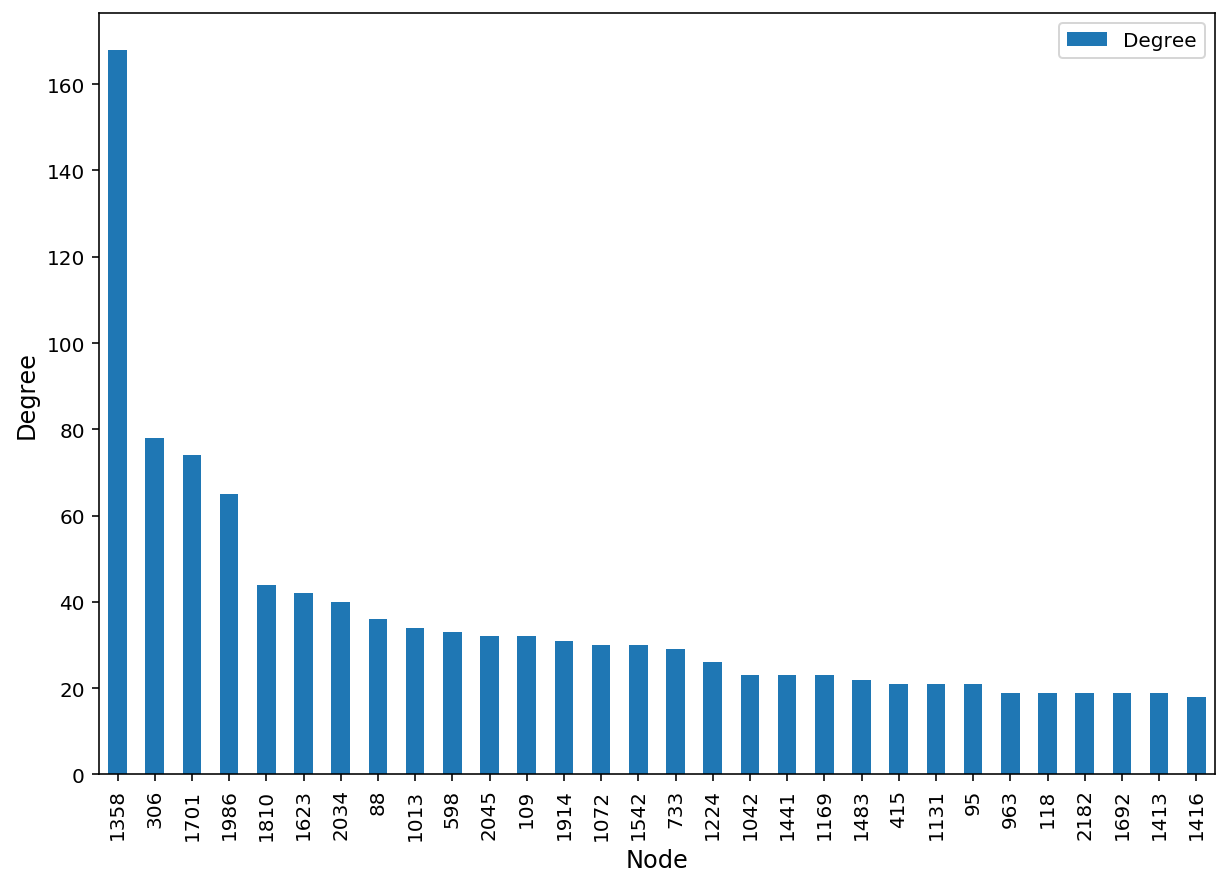

In [16]:
## 使用直方图可视化度较多的前30个节点的度
Node_degree.iloc[0:30,:].plot(x = "Node",y = "Degree",
                              kind = "bar",figsize = (10,7))
plt.xlabel("Node",size = 12)
plt.ylabel("Degree",size = 12)
plt.show()

In [17]:
pos = nx.spring_layout(CoraNet) # 网络图中节点的布局方式

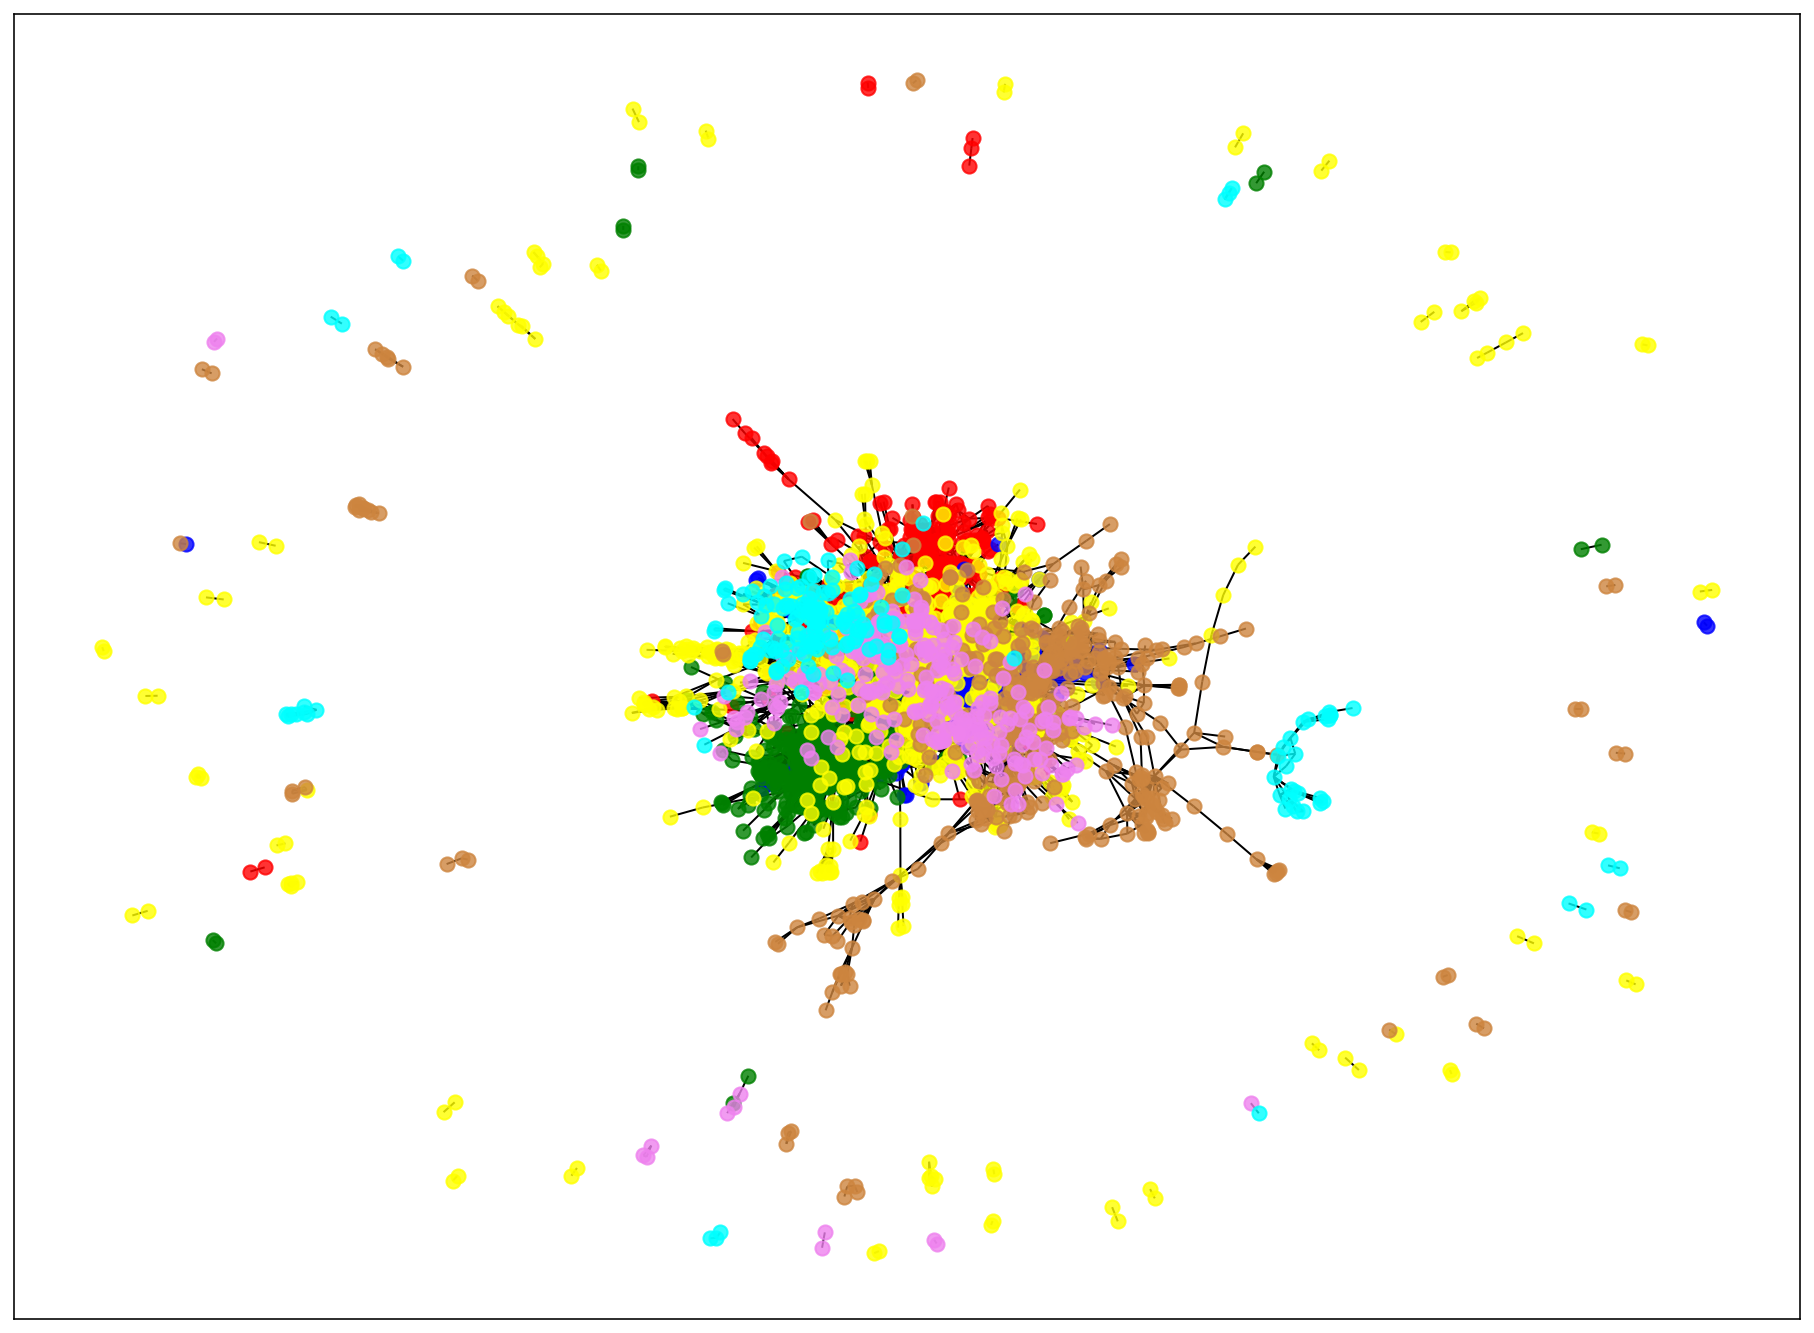

In [18]:
nodecolor = ["red","blue","green","yellow","peru","violet","cyan"] ## 颜色
nodelabel = np.array(list(CoraNet.nodes))  # 节点
## 使用networkx库将网络图进行可视化
plt.figure(figsize=(16,12))
## 为不同类别的节点使用不同的颜色
for ii in np.arange(len(np.unique(Node_class))):
    nodelist = nodelabel[Node_class == ii]# 对应类别的节点
    nx.draw_networkx_nodes(CoraNet, pos,nodelist=list(nodelist),
                           node_size=50,   # 节点大小
                           node_color=nodecolor[ii], #节点颜色
                           alpha=0.8)
# 为网络添加边
nx.draw_networkx_edges(CoraNet, pos,width=1,edge_color="black")
plt.show()

#### 可视化出训练集、验证集和测试机中节点再网络图中的位置

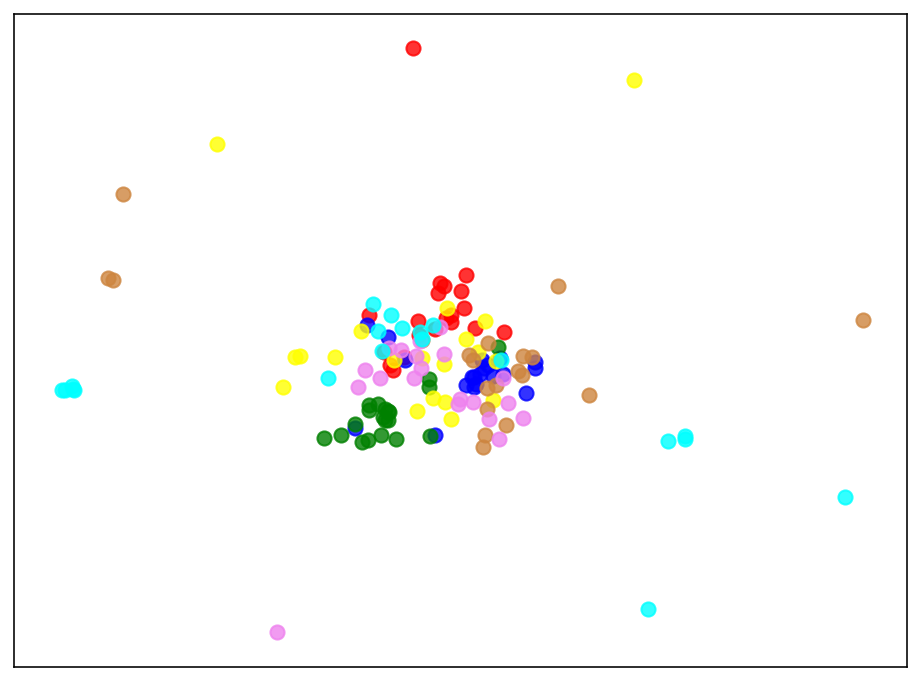

In [19]:
## 可视化训练集的节点分布
nodecolor = ["red","blue","green","yellow","peru","violet","cyan"] ## 颜色
nodelabel = np.arange(0,140)  # 测试机的节点位置
Node_class = dataset.data.y.data.numpy()[0:140]
## 使用networkx库将网络图进行可视化
plt.figure(figsize=(8,6))
## 为不同类别的节点使用不同的颜色
for ii in np.arange(len(np.unique(Node_class))):
    nodelist = nodelabel[Node_class == ii]# 对应类别的节点
    nx.draw_networkx_nodes(CoraNet, pos,nodelist=list(nodelist),
                           node_size=50,   # 节点大小
                           node_color=nodecolor[ii], #节点颜色
                           alpha=0.8)
plt.show()

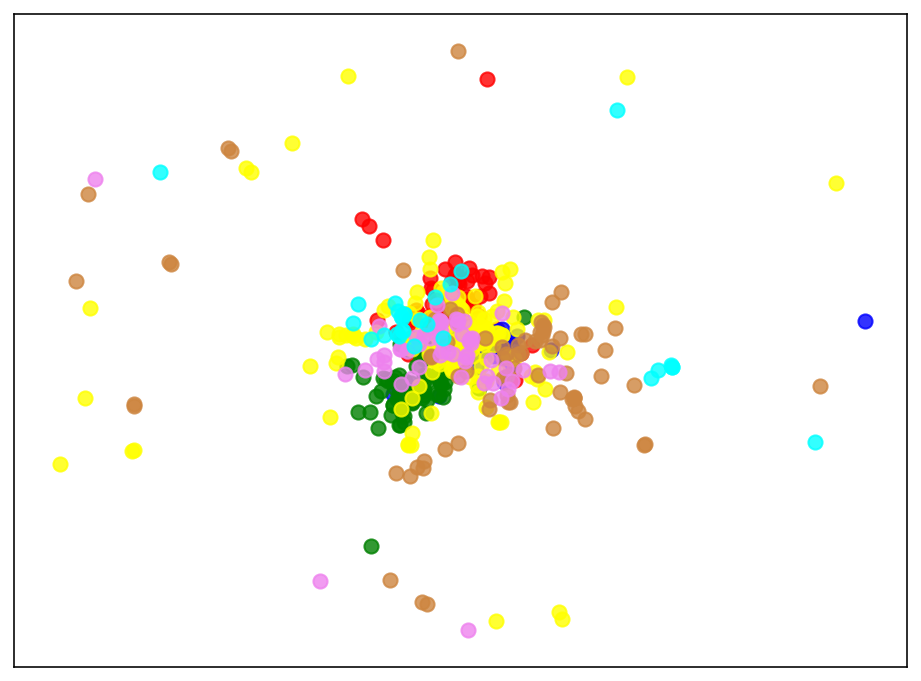

In [20]:
## 可视化验证集的节点分布，141～640
nodecolor = ["red","blue","green","yellow","peru","violet","cyan"] ## 颜色
nodelabel = np.arange(141,640)  # 测试机的节点位置
Node_class = dataset.data.y.data.numpy()[141:640]
## 使用networkx库将网络图进行可视化
plt.figure(figsize=(8,6))
## 为不同类别的节点使用不同的颜色
for ii in np.arange(len(np.unique(Node_class))):
    nodelist = nodelabel[Node_class == ii]# 对应类别的节点
    nx.draw_networkx_nodes(CoraNet, pos,nodelist=list(nodelist),
                           node_size=50,   # 节点大小
                           node_color=nodecolor[ii], #节点颜色
                           alpha=0.8)
plt.show()

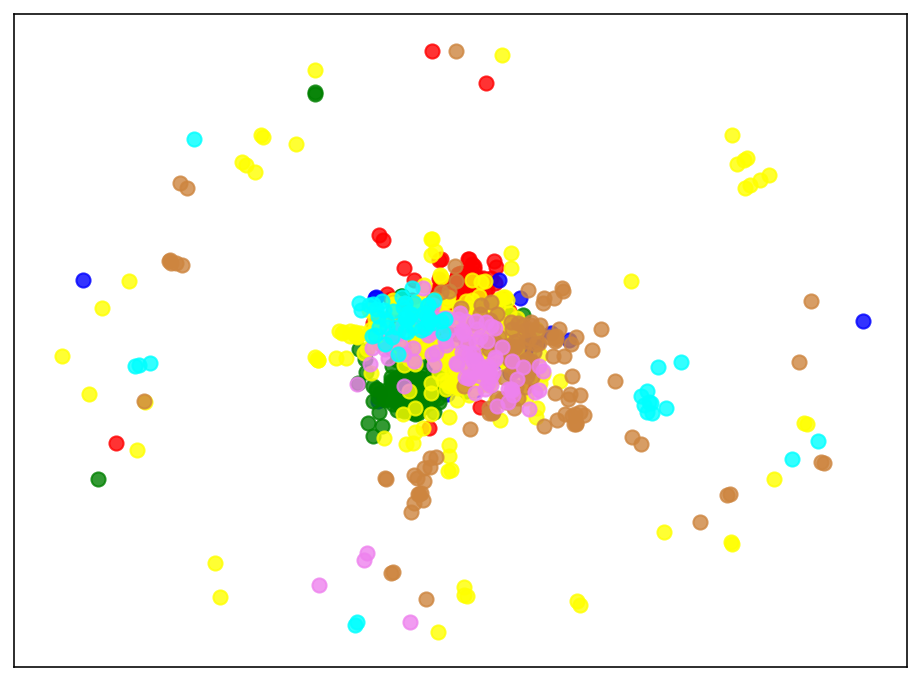

In [21]:
## 可视化测试集的节点分布，1708～2708
nodecolor = ["red","blue","green","yellow","peru","violet","cyan"] ## 颜色
nodelabel = np.arange(1708,2708)  # 测试机的节点位置
Node_class = dataset.data.y.data.numpy()[1708:2708]
## 使用networkx库将网络图进行可视化
plt.figure(figsize=(8,6))
## 为不同类别的节点使用不同的颜色
for ii in np.arange(len(np.unique(Node_class))):
    nodelist = nodelabel[Node_class == ii]# 对应类别的节点
    nx.draw_networkx_nodes(CoraNet, pos,nodelist=list(nodelist),
                           node_size=50,   # 节点大小
                           node_color=nodecolor[ii], #节点颜色
                           alpha=0.8)
plt.show()

### 使用GCN网络对数据进行训练和预测



In [22]:
## 构建一个网络类
class GCNnet(torch.nn.Module):
    def __init__(self,input_feature,num_classes):
        super(GCNnet, self).__init__()
        # 输入数据中每个节点的特征数量
        self.input_feature = input_feature 
        self.num_classes = num_classes # 数据的类别数量
        self.conv1 = GCNConv(input_feature , 32)
        self.conv2 = GCNConv(32, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # 使用Relu激活函数
        x = self.conv2(x, edge_index)
        ## 输出使用softmax函数进行处理
        return F.softmax(x, dim=1)



In [23]:
## 初始化网络
input_feature  = dataset.num_node_features
num_classes = dataset.num_classes
mygcn = GCNnet(input_feature,num_classes)
mygcn

GCNnet(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)

In [24]:
## 对网络进行训练，全部数据作为一个batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mygcn.to(device)   # 网络设置到指定计算设备
data = dataset[0].to(device) # 数据设置到指定计算设备
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, 
                             weight_decay=5e-4)

train_loss_all = []  # 保存每个epoch训练集的损失
val_loss_all = []  # 保存每个epoch验证集的损失
model.train()  # 模型设置为训练模式
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # 计算损失时只使用训练集的类别标签
    loss = F.cross_entropy(out[data.train_mask],
                           data.y[data.train_mask])
    loss.backward()    # 损失后项传播
    optimizer.step()   # 优化参数
    train_loss_all.append(loss.data.numpy()) 
    
    ## 计算再验证集上的损失
    loss = F.cross_entropy(out[data.val_mask],
                           data.y[data.val_mask])
    val_loss_all.append(loss.data.numpy()) 
    if epoch % 20 == 0:  # 每20个epoch输出一个损失
        ## 计算再验证集上的损失
        print("epoch:",epoch,"; Train Loss:",train_loss_all[-1],
              "; Val Loss:",val_loss_all[-1])

epoch: 0 ; Train Loss: 1.9466406 ; Val Loss: 1.9477787
epoch: 20 ; Train Loss: 1.1882339 ; Val Loss: 1.4673576
epoch: 40 ; Train Loss: 1.1761099 ; Val Loss: 1.4502563
epoch: 60 ; Train Loss: 1.1785218 ; Val Loss: 1.4543782
epoch: 80 ; Train Loss: 1.1759216 ; Val Loss: 1.4481095
epoch: 100 ; Train Loss: 1.1748766 ; Val Loss: 1.4438468
epoch: 120 ; Train Loss: 1.1741211 ; Val Loss: 1.4411005
epoch: 140 ; Train Loss: 1.1735991 ; Val Loss: 1.4390937
epoch: 160 ; Train Loss: 1.1732321 ; Val Loss: 1.4376124
epoch: 180 ; Train Loss: 1.1729643 ; Val Loss: 1.436538


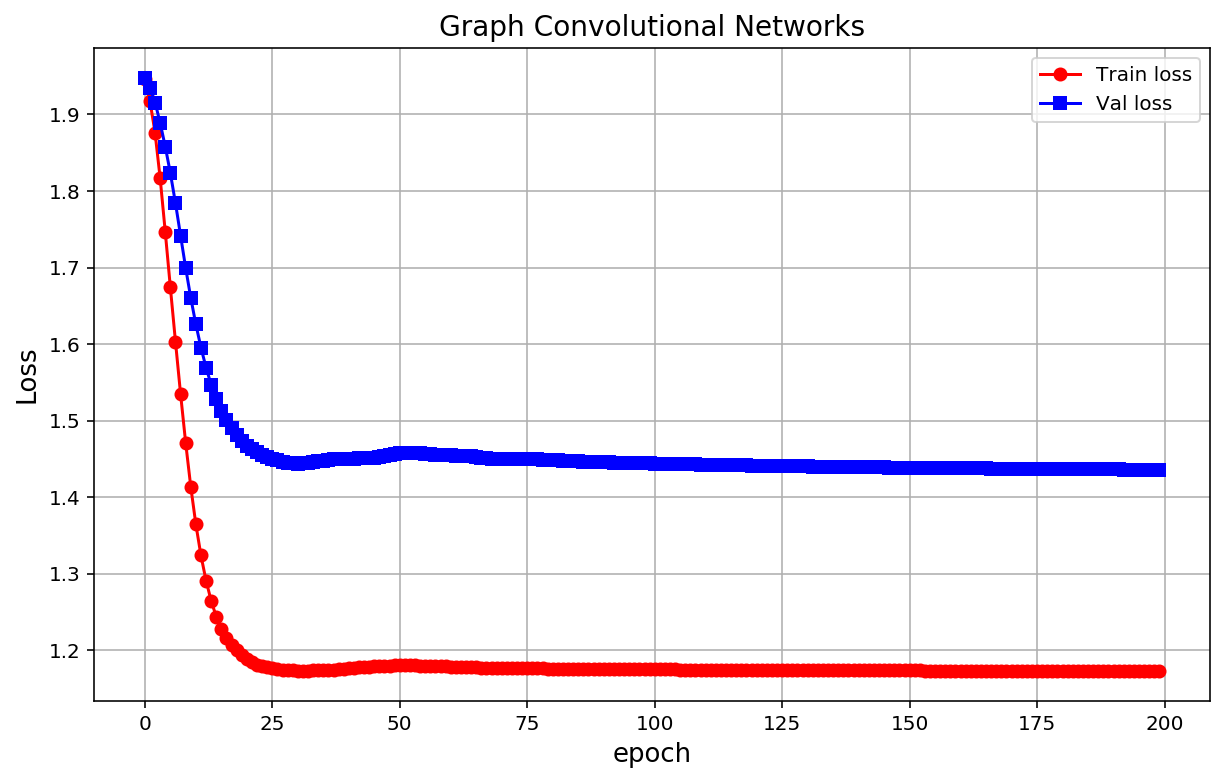

In [25]:
## 可视化损失函数的变化情况
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label = "Train loss")
plt.plot(val_loss_all,"bs-",label = "Val loss")
plt.legend()
plt.grid()
plt.xlabel("epoch",size = 13)
plt.ylabel("Loss",size = 13)
plt.title("Graph Convolutional Networks",size = 14)
plt.show()

In [26]:
## 计算网络模型再测试集上的预测精度
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()  # 计算精度
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.8030


### 获取所有节点的隐藏层学习得到的特征表示，用于可视化分析

为了对比，同时可视化出元素1433维降维的可视化图像

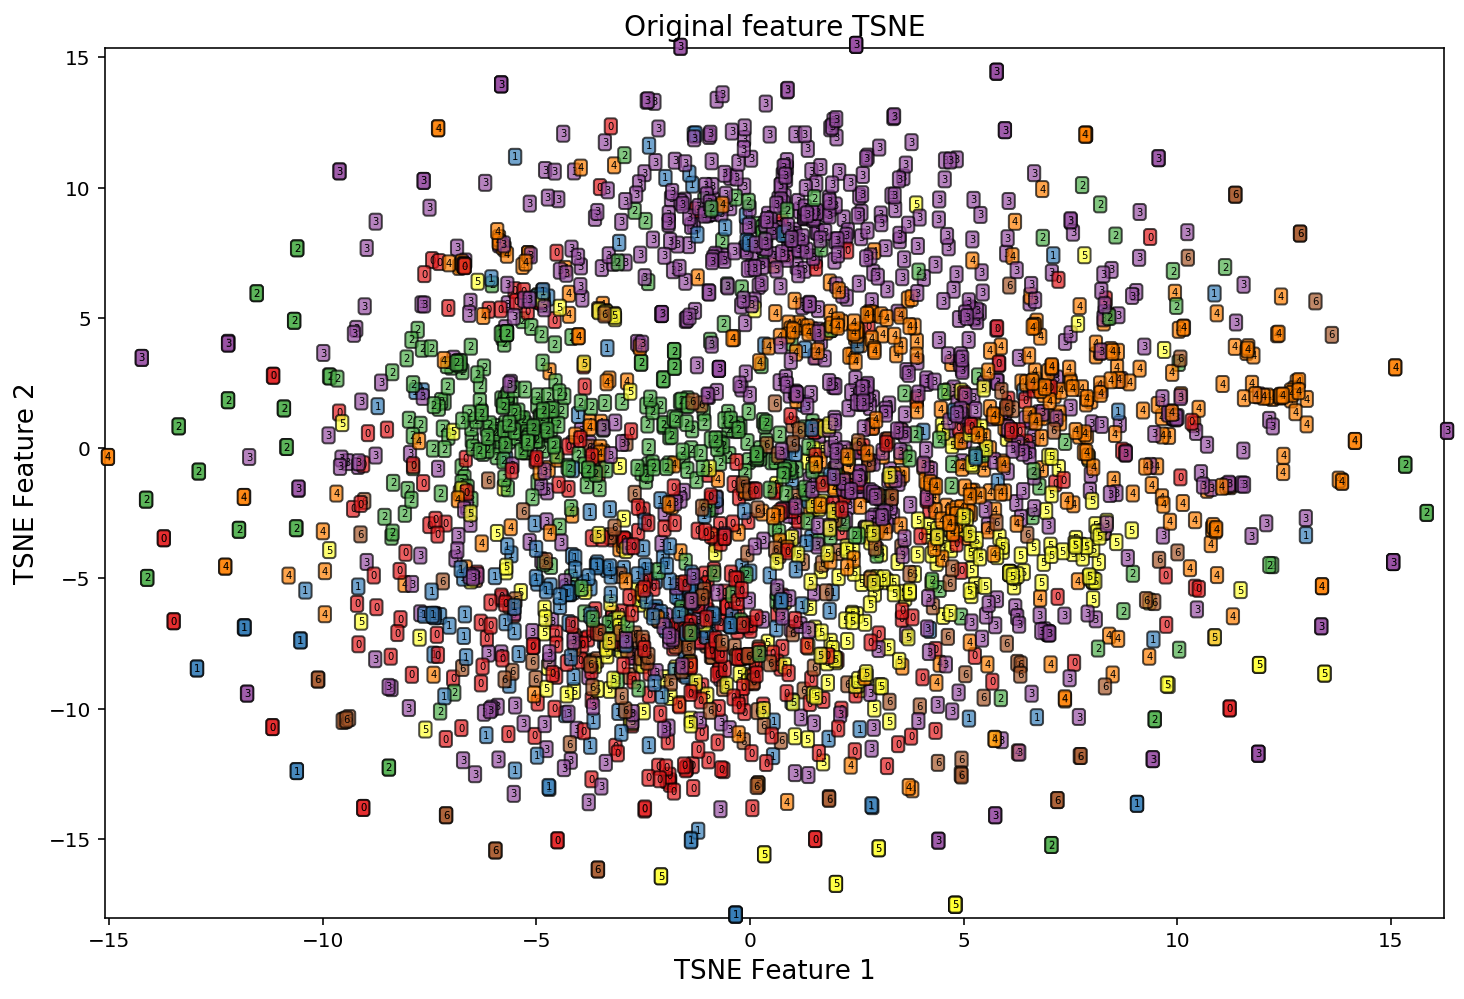

In [27]:
## 将数据的原始特征使用tsne进行降维可视化
x_tsne = TSNE(n_components=2).fit_transform(dataset.data.x.data.numpy())

## 对降维后的数据进行可视化
plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 1, 1)
X = x_tsne[:,0]
Y = x_tsne[:,1]
ax1.set_xlim([min(X),max(X)])
ax1.set_ylim([min(Y),max(Y)])
for ii in range(x_tsne.shape[0]):
    text = dataset.data.y.data.numpy()[ii]
    ax1.text(X[ii],Y[ii,],str(text),fontsize=5,
             bbox=dict(boxstyle="round",facecolor=plt.cm.Set1(text),alpha=0.7))
ax1.set_xlabel("TSNE Feature 1",size = 13)
ax1.set_ylabel("TSNE Feature 2",size = 13)
ax1.set_title("Original feature TSNE",size = 14)
plt.show()

In [28]:
## 使用钩子获取分类层的2个特征,定义一个辅助函数，来获取指定层名称的特征
activation = {} ## 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## 获取隐藏层的特征输出
model.conv1.register_forward_hook(get_activation("conv1"))
_ = model(data)
conv1 = activation["conv1"].data.numpy()
print("conv1.shape:",conv1.shape)
## 每个节点的1433个特征降维到了32

conv1.shape: (2708, 32)


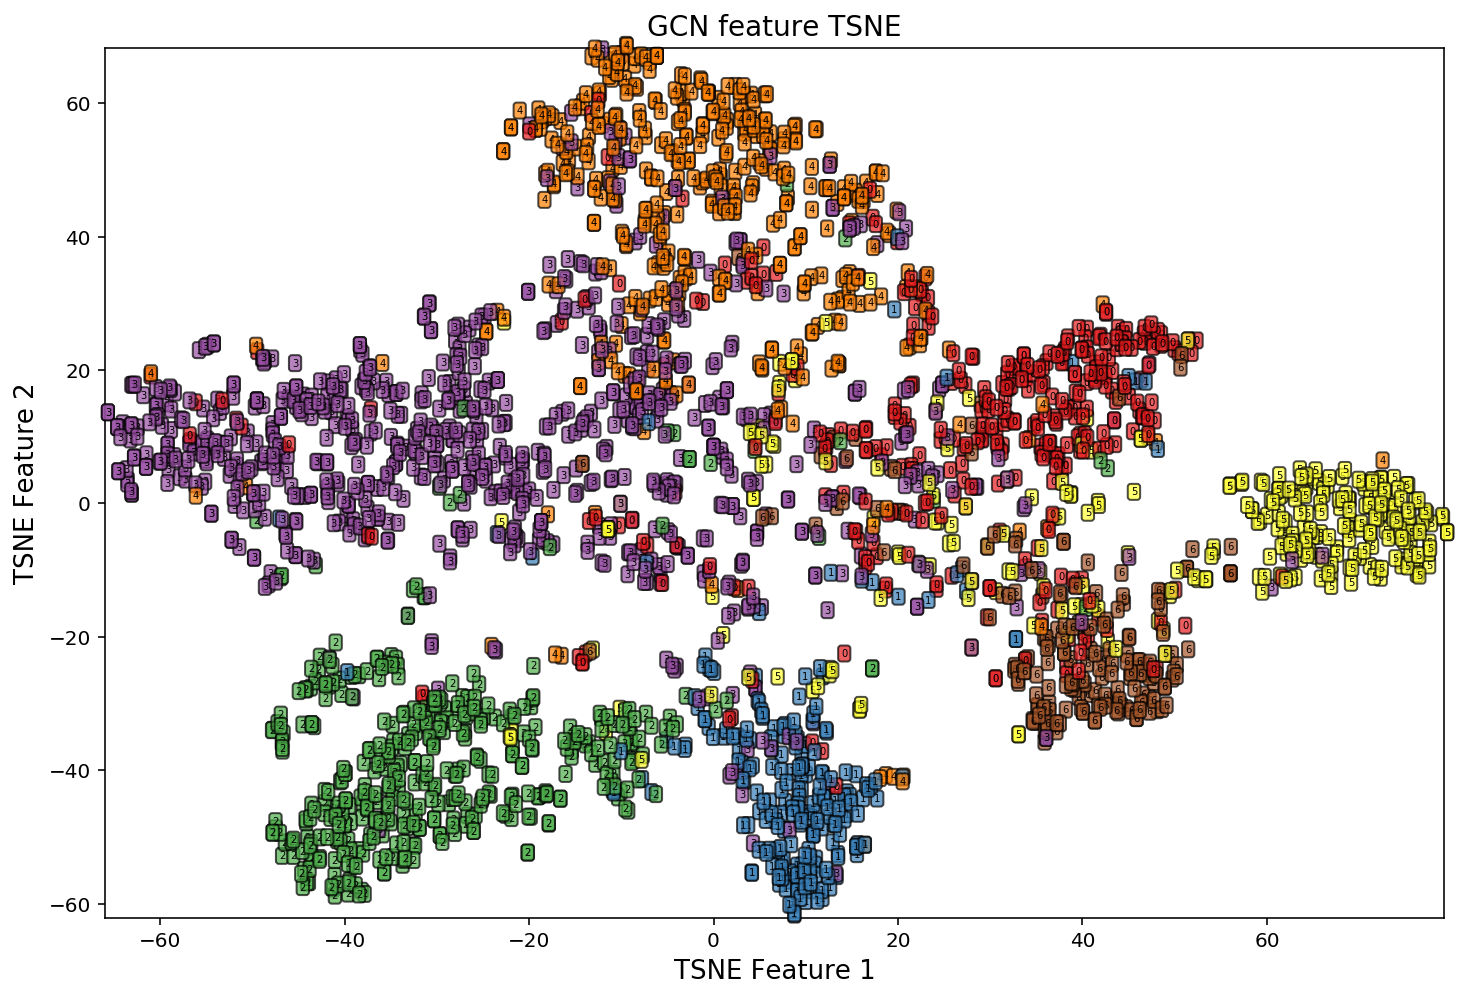

In [29]:
## 使用tsne对数据进行降维观察数据的分布情况
conv1_tsne = TSNE(n_components=2).fit_transform(conv1)

## 对降维后的数据进行可视化
plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 1, 1)
X = conv1_tsne[:,0]
Y = conv1_tsne[:,1]
ax1.set_xlim([min(X),max(X)])
ax1.set_ylim([min(Y),max(Y)])
for ii in range(conv1_tsne.shape[0]):
    text = dataset.data.y.data.numpy()[ii]
    ax1.text(X[ii],Y[ii,],str(text),fontsize=5,
             bbox=dict(boxstyle="round",facecolor=plt.cm.Set1(text),alpha=0.7))
ax1.set_xlabel("TSNE Feature 1",size = 13)
ax1.set_ylabel("TSNE Feature 2",size = 13)
ax1.set_title("GCN feature TSNE",size = 14)
plt.show()

### 使用支持向量机建立分类器模型，查看模型的效果

In [30]:
## 使用到的数据转化为numpy数组
X = dataset.data.x.data.numpy()
Y = dataset.data.y.data.numpy()
train_mask = dataset.data.train_mask.data.numpy()
test_mask = dataset.data.test_mask.data.numpy()
## 准备训练数据和测试数据
train_x = X[0:140,:]
train_y = Y[train_mask]
test_x = X[1708:2708,:]
test_y = Y[test_mask]

In [31]:
## 使用训练集训练SVM模型，并使用测试集进行预测
svmmodel = SVC()
svmmodel.fit(train_x,train_y)  #训练
prelab = svmmodel.predict(test_x) # 预测
print("SVM的预测精度:",accuracy_score(test_y,prelab))

/Users/daitu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM的预测精度: 0.583


### 使用半监督模型LabelPropagation(标签传播分类器)对数据进行学习预测

In [32]:
## 数据准备
## 使用到的数据转化为numpy数组
X = dataset.data.x.data.numpy()
Y = dataset.data.y.data.numpy()
train_mask = dataset.data.train_mask.data.numpy()
test_mask = dataset.data.test_mask.data.numpy()
## 不是训练数据的样本标签使用－1表示
train_y = Y.copy()  
train_y[test_mask == True] = -1 # 使用训练数据和验证试数据作为训练集
## 预测数据 
test_y = Y[test_mask]

In [33]:
## 训练标签传播分类器
lp_model = label_propagation.LabelPropagation(kernel="knn",n_neighbors=3)
lp_model.fit(X,train_y)
## 输出标签传播训练得到的预测标签
prelab = lp_model.transduction_
# 计算再测试机上的预测精度
print("LP的预测精度:",accuracy_score(Y[test_mask],prelab[test_mask]))

## 精度没有高过支持向量机

/Users/daitu/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: divide by zero encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/daitu/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


LP的预测精度: 0.432


/Users/daitu/anaconda3/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
